## In the following notebook, we simulate the experiment used to determine the quantum efficiency $\eta$ of a measurement setup by analyzing the integrated voltages obtained from weakly measuring the qubit using heterodyne detection.

- By Élie Genois, 2020-05-15

### Step 0: Verify that Qutip's smesolve() function implementation correct. See pull request #1237 for qutip/stochastic.py in version 4.5.0 for more details.

In [1]:
import qutip
import matplotlib.pyplot as plt
import numpy as np
import pdb

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
qutip.__version__

'4.5.0'

Verify that the correction is effective on smesolve() with a simple trajectory computation on a given (not important) setup.

In [3]:
solver='milstein'
H = qutip.sigmax() # Rabi drive X
L = qutip.sigmaz() # Weak measurement of Z
dt = 1/2**8

rho_0 = (qutip.qeye(2) + qutip.sigmax())/2 # Prepare +X

seq_len = 32
times = np.linspace(0, dt*seq_len, seq_len+1)
dt = times[1] - times[0]


#seed = [10, 20]
seed = None

result_milstein = qutip.smesolve(H, rho_0, times,
                                 sc_ops=[L], 
                                 e_ops=[qutip.qeye(2), qutip.sigmax(), qutip.sigmay(), qutip.sigmaz(), 
                                        L+L.dag(), -1j*(L-L.dag()), -1j*L-L.dag()], # Extract complete info
                                 method='heterodyne', solver=solver, store_measurement=True, 
                                 noise=seed)

# dMs = sqrt(2)*dWs + L_Ldag[1:] * dt  is our correspondance here with the correct slicing.
dWs = result_milstein.noise[0, :-1, 0, :]

L_Ldag = result_milstein.expect[4][:]
iL_Ldag = result_milstein.expect[5][:]       # Correct operator implementation
wrong_iL_Ldag = result_milstein.expect[6][:] # Wrong implementation before PR #1237

dMs = np.real(result_milstein.measurement[0])[:-1,0,:] * dt 
            
# [<I>=Tr{\rho}, <X>, <Y>, <Z>]
smetraj_milstein = np.array([result_milstein.expect[0][:], result_milstein.expect[1][:], 
                            result_milstein.expect[2][:], result_milstein.expect[3][:]]) 

Total run time:   0.00s


In [4]:
# I quadrature
dMs[:, 0] == np.sqrt(2)*dWs[:, 0] + L_Ldag[1:] * dt

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

In [5]:
# True Q quadrature
dMs[:, 1] == np.sqrt(2)*dWs[:, 1] + iL_Ldag[1:] * dt

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

Those two last outputs **should be all 'True's** and the following must be 'False's.

In [6]:
# Known wrong Q quadrature
dMs[:, 1] == np.sqrt(2)*dWs[:, 1] + np.real(wrong_iL_Ldag[1:]) * dt

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False])

 ---

Verify that the same is true for the rouchon solver, which uses a different scheme (_positive_map)

In [7]:
solver='rouchon'

result_rouchon = qutip.smesolve(H, rho_0, times,
                                 sc_ops=[L], 
                                 e_ops=[qutip.qeye(2), qutip.sigmax(), qutip.sigmay(), qutip.sigmaz(), 
                                        L+L.dag(), -1j*(L-L.dag()), -1j*L-L.dag()], # Extract complete info
                                 method='heterodyne', solver=solver, store_measurement=True, 
                                 noise=seed)

# dMs = sqrt(2)*dWs + L_Ldag[1:] * dt  is our correspondance here with the correct slicing.
dWs = result_rouchon.noise[0, :-1, 0, :]

L_Ldag = result_rouchon.expect[4][:]
iL_Ldag = result_rouchon.expect[5][:]
wrong_iL_Ldag = result_rouchon.expect[6][:]

dMs = np.real(result_rouchon.measurement[0])[:-1,0,:] * dt 
            
# [<I>=Tr{\rho}, <X>, <Y>, <Z>]
smetraj_rouchon = np.array([result_rouchon.expect[0][:], result_rouchon.expect[1][:], 
                            result_rouchon.expect[2][:], result_rouchon.expect[3][:]]) 

Total run time:   0.00s


In [8]:
# I quadrature
dMs[:, 0] == np.sqrt(2)*dWs[:, 0] + L_Ldag[1:] * dt

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

In [9]:
# True Q quadrature
dMs[:, 1] == np.sqrt(2)*dWs[:, 1] + iL_Ldag[1:] * dt

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

In [10]:
# Known wrong Q quadrature
dMs[:, 1] == np.sqrt(2)*dWs[:, 1] + np.real(wrong_iL_Ldag[1:]) * dt

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False])

If everything is in order, can move to step 1. If not, try updating qutip, or explicitely implementing the change of PR #1237 in your local installation of qutip.

----

### Step 1: Generation of the data used to obtain $\eta$

In essence, we prepare the $|+\rangle$ state and weakly measure Z. The resulting backaction will gradually push the qubit state either towards $|0\rangle$ or $|1\rangle$. The total integrated voltage coming from the weak measurement should inform on which of the two bases the qubit was moving towards, e.g. let's say its positive for $|0\rangle$ and negative for $|1\rangle$. Then, repeating the experiment (nb_shots times) will allow us to build a distribution that has the form of a double gaussian centered at 0 with shared standard deviation.
As such, this distribution as 2 parameters, $\mu$ and $\sigma$.
We will then estimate those 2 best parameters representing the double gaussian that the distribution originates from using maximum likelihood estimation (MLE). 

The separation and spread of the gaussians will give us the SNR, computed as follow

\begin{equation}
SNR^2 = \frac{\left(2 \mu_{\mathrm{MLE}}\right)^2}{\sigma^2_{\mathrm{MLE}}},
\end{equation}

which we will then use to fit to the expectation value of X over different total integration times, as follow

\begin{equation}
\langle X \rangle = \exp{\frac{-SNR^2}{8\eta_{fit}}}
\end{equation}

Using L=Z, all the information will be in the $I$ quadrature since the operators setting the deterministic parts of the weak measurements are $\langle L+L^\dagger\rangle=\langle2Z\rangle$ for $I$ and $\langle -i(L-L^\dagger)\rangle=\langle0\rangle$ for $Q$, thus simplifying everything for us.

For another setup (non-hermitian L operator) or a real experiment where the information will never be perfectly aligned in one of the two measured quadratures, a Principal Component Analysis (https://intoli.com/blog/pca-and-svd/) of the distribution will allow to find the direction in which the double gaussian is actually present. In those cases, an additional step to first align the double gaussian in the optimal direction is thus required. It is not implemented in this actual notebook.

In [11]:
import qutip
import itertools as it
import numpy as np
import torch
from tqdm.notebook import trange, tnrange

import pdb
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [12]:
def gen_data_eta_exp(nb_shots, seq_len, dt, H, L, solver='rouchon', seed=None, eta=1.):
    ''' 
    Function that generate the data used for fitting the quantum efficiency of measurement 
    using qutip's smesolve.
    
    nb_shots (int): Number of repetition for a given total integration time (T).
    seq_len (int): Number of time steps; seq_len*dt=T.
    dt (float): Time step size.
    H (qutip operator): hamiltonian of the system
    L (qutip operator): Lindblad operator corresponding to the coupling of the measurement apparatus to the system.
    solver (str): solver used for the integration. Use 'rouchon', 'milstein', 'taylor1.5' or 'taylor2'.
    seed (list of 3 ints): seed for the sampling of 2 random distributions for stochastic integrator and 
                           for the uniform ditribution used to build the final outcome of projective measurement.
    eta (float): Actual quantum efficiency that we want to recover using the weak measurement record.
    
    '''
    
    # Integration times.
    times = np.linspace(0, dt*seq_len, seq_len+1)
    dt = times[1] - times[0]
    # Initial state of the system.
    rho_init = (qutip.qeye(2) + qutip.sigmax())/2
    
    inputs = []
    outcomes = []
    
    # Let's build those measurement records and corresponding settings and outcomes.
    all_dWs = np.zeros((1, nb_shots, len(times), 1, 2))
    if seed:
        RS1 = np.random.RandomState(seed[0])
        RS2 = np.random.RandomState(seed[1])
        RS3 = np.random.RandomState(seed[2])
        all_dWs[0, :, :, 0, 0] = RS1.normal(scale=np.sqrt(dt), size=(nb_shots, len(times)))
        all_dWs[0, :, :, 0, 1] = RS2.normal(scale=np.sqrt(dt), size=(nb_shots, len(times)))
        unifs = RS3.uniform(size = (nb_shots))
    else:
        all_dWs[0, :, :, 0, 0] = np.random.normal(scale=np.sqrt(dt), size=(nb_shots, len(times)))
        all_dWs[0, :, :, 0, 1] = np.random.normal(scale=np.sqrt(dt), size=(nb_shots, len(times))) 
        unifs = np.random.uniform(size = (nb_shots))
    
    # Loop integrating nb_shots times the SME using different noise realizations to build up the 
    # weak measurement record distributions.
    k = 0
    for traj_idx in tnrange(nb_shots):
        result = qutip.smesolve(H, rho_init, times,
                                c_ops=[np.sqrt(1-eta) * L],
                                sc_ops=[np.sqrt(eta) * L], 
                                e_ops=[qutip.sigmax()],
                                method='heterodyne', solver=solver, store_measurement=True, 
                                noise=all_dWs[:, k, :, :, :])
                
        dMs = np.real(result.measurement[0])[:-1,0,:] * dt         # SLICING IMPORTANT
        # The correspondances must be:
        #dMs[:, 0] == np.sqrt(2)*dWs[:, 0] + c_cdag[1:] * dt       # I quadrature
        #dMs[:, 1] == np.sqrt(2)*dWs[:, 1] + ic_cdag[1:] * dt      # Q quadrature
        # Implying the importance of the slicing in the following.
        #dWs = result.noise[0, :-1, :]
        
        # Append the measurements
        inputs.append(np.sum(dMs, axis=0))

        # P0 is the probability of measuring the +eigenstate
        P0 = (result.expect[0][-1] + 1)/2

        # Returns 0 if you measure the +eigenstate and 1 if -eigenstate.
        outcomes.append(0 if unifs[k] <= P0 else 1)

        k += 1

    inputs = np.array(inputs, dtype=np.float)
    outcomes = np.array(outcomes, dtype=np.float)
    unifs = np.array(unifs, dtype=np.float)
    
    I = inputs[:, 0]
    Q = inputs[:, 1]

    
    # <X> = exp(-SNR/8*eta) >~ 0.
    exp_X = 1 - 2*np.mean(outcomes)
    
    output_dict = {"I":I, "Q":Q, "exp_X":exp_X,
                   'inputs':inputs, 'outcomes':outcomes, 
                   "unifs":unifs, "H":H, "L":L, "solver":solver,
                   "times":times, "dt":dt
                  }
    
    return output_dict


In [13]:
import os, sys

# Function to avoid the prints of qutip.smesolve() function for every trajectory.
# (Quick fix instead of playing with qutip's print setups)
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

with HiddenPrints():
    print("This will not be printed")

print("This will be printed as before")

This will be printed as before


In [14]:
# Takes about 30min.
from scipy.optimize import fsolve

# Fix a given quantum efficiency \eta that we will try to find back.
eta = 0.85
# Simple setup with no drive and weakly measuring Z as mentioned above.
H = qutip.qzero(2)
L = qutip.sigmaz()
dt = 1/2**8
nb_shots = int(1e4) # Could use more shots to get better distributions (longer to compute).

# Total integration times (T) used to fit the exponential
seq_lens = np.arange(2**7, 2**9, 20)
# final_times := T
final_times = seq_lens * dt

mean_I_list = []
stdsq_I_list = []
mean_Q_list = []
stdsq_Q_list = []
SNRsqu_I_list = []
SNRsqu_Q_list = []
exp_X_list = []

# We work with a Density Function of a double gaussian centered at 0 with means at +/- mu and shared sigma.

def MLE_eqs(p):
    """
    Maximum likelihood estimation equations for mu and sigsq:=sigma^2.
    Reference to global variables obtained from the trajectories directly, 
    which is the simplest thing to do but does not look great (sorry about that).
    """
    mu, sigsq = p
    return (-len(I)*mu + np.sum(I*np.tanh((I*mu)/sigsq)), 
           len(I)*(mu**2-sigsq) + np.sum(I**2-2*I*mu*np.tanh((I*mu)/sigsq)))

# All the information is in the I quadrature, but we compute for I and Q to be complete.
for i in tnrange(len(seq_lens)):
    with HiddenPrints():
        all_data = gen_data_eta_exp(nb_shots=nb_shots, seq_len=seq_lens[i], dt=dt, H=H, L=L, 
                                    solver='rouchon', seed=None, eta=eta)
    
    # The resulting expectation value of X for these trajectories.
    exp_X  = all_data['exp_X']
    
    # We then obtain the SNR squared from the distribution.    
    # For the I quadrature
    I  = all_data['I']
    mu_I_MLE, sigsq_I_MLE = fsolve(MLE_eqs, (4, 2))     # (4,2) are the initial guess for mu and sigsq.
    SNRsqu_I = (2*mu_I_MLE) ** 2 / sigsq_I_MLE
    
    # For the Q quadrature
    I  = all_data['Q']                                  # because of our naming convention for MLE_eqs.
    mu_Q_MLE, sigsq_Q_MLE = fsolve(MLE_eqs, (0, 1))     # (0,1) are the initial guess for mu and sigsq.
    SNRsqu_Q = (2*mu_Q_MLE) ** 2 / sigsq_Q_MLE
    
    SNRsqu_I_list.append(SNRsqu_I)
    SNRsqu_Q_list.append(SNRsqu_Q)
    exp_X_list.append(exp_X)
    
    mean_I_list.append(mu_I_MLE)
    stdsq_I_list.append(sigsq_I_MLE)
    mean_Q_list.append(mu_Q_MLE)
    stdsq_Q_list.append(sigsq_Q_MLE)

SNRsqu_I_list = np.array(SNRsqu_I_list, dtype=np.float)
SNRsqu_Q_list = np.array(SNRsqu_Q_list, dtype=np.float)
exp_X_list = np.array(exp_X_list, dtype=np.float)

/opt/miniconda3/envs/elie-env/lib/python3.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 600.
  warnings.warn(msg, RuntimeWarning)


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



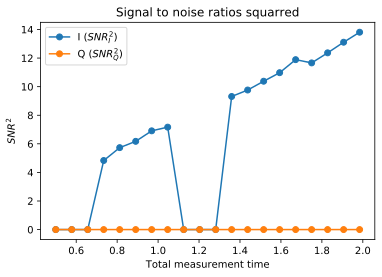

In [15]:
# Let's look at how the SNR evolves as we take longer total integration times
plt.plot(final_times, SNRsqu_I_list, 'o-', label=r'I ($SNR^2_I$)')
plt.plot(final_times, SNRsqu_Q_list, 'o-', label=r'Q ($SNR^2_Q$)')
plt.title('Signal to noise ratios squarred')
plt.xlabel('Total measurement time')
plt.ylabel(r'$SNR^2$')
plt.legend()
plt.show()

As expected, there is no information in the $Q$ quadrature. The bumps to zero are artefact from the non-convergence of the MLE using scipy fsolve(). They should be ignored.

10000


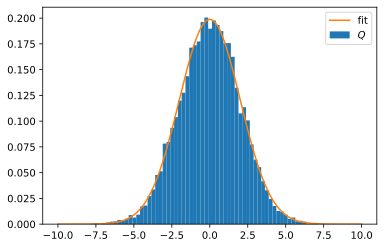

10000


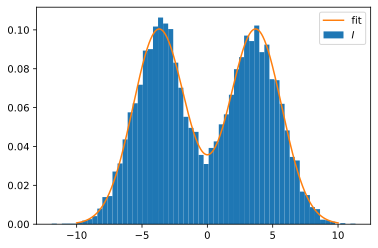

In [16]:
# Let's look at the I and Q distribution and their corresponding double gaussian fit,
# for the last (longest) integration time used.
I  = all_data['I']
Q  = all_data['Q']


def DF_double_gaussian(x, mu, sigsq):
    'Density Function of a double gaussian centered at 0 with means at +/- mu and shared sigma.'
    return (np.exp(-(x-mu)**2/(2*sigsq)) + np.exp(-(x+mu)**2/(2*sigsq))) / (2 * np.sqrt(2*np.pi*sigsq))

x = np.linspace(-10, 10, 1000)

print(len(Q))
plt.hist(Q, bins=60, density=True, label=r'$Q$')
plt.plot(x, DF_double_gaussian(x, mean_Q_list[-1], stdsq_Q_list[-1]), label='fit')
plt.legend()
plt.show()

print(len(I))
plt.hist(I, bins=60, density=True, label=r'$I$')
plt.plot(x, DF_double_gaussian(x, mean_I_list[-1], stdsq_I_list[-1]), label='fit')
plt.legend()
plt.show()

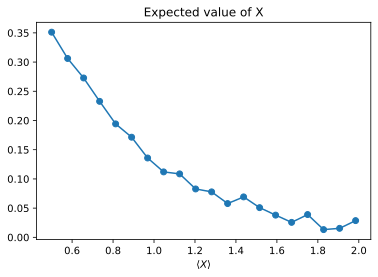

In [17]:
# Let's look at the expectation value of X which should follow an exponential decay.
plt.plot(final_times, exp_X_list, 'o-')
plt.title('Expected value of X')
plt.xlabel('Total measurement time')
plt.xlabel(r'$\langle X \rangle$')
#plt.legend()
plt.show()

----

## Step 2: Obtain $\eta$ by fitting the $\langle X \rangle$ decay.

In [18]:
from scipy.optimize import curve_fit

def func1(i, eta):
    i = np.array(i, dtype=np.int)
    return np.exp(-SNRsqu_I_list[i]/8/eta)

eta_fitted, pcov = curve_fit(func1, np.arange(len(seq_lens)), exp_X_list)

print(r'The experiment gave a SNR corresponding to a eta of {:.3f}%'.format(eta_fitted[0]*100))

The experiment gave a SNR corresponding to a eta of 42.628%


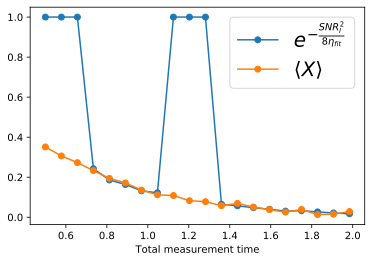

In [19]:
# Let's look at this fitted decay
plt.plot(final_times, np.exp(-SNRsqu_I_list/8/eta_fitted[0]), 'o-',  label=r'$e^{-\frac{SNR^2_I}{8 \eta_{fit}}}$')
#plt.plot(final_times, np.exp(-SNRsqu_Q_list/8/eta), 'o-', label=r'$e^{-\frac{SNR^2_Q}{8 \eta}}$')
plt.plot(final_times, exp_X_list, 'o-', label=r'$\langle X \rangle$')
plt.xlabel('Total measurement time')
plt.legend(fontsize=20)
plt.show()

With a mask removing the data points where the fsolve() optimization did not converge, we obtain the following similar $\eta$.

In [20]:
mask = np.squeeze(np.argwhere(SNRsqu_I_list>1e-4))

eta_fitted_mask, pcov = curve_fit(func1, mask, exp_X_list[mask])

print(r'This gives a eta of {:.3f}%'.format(eta_fitted_mask[0]*100))

This gives a eta of 42.630%


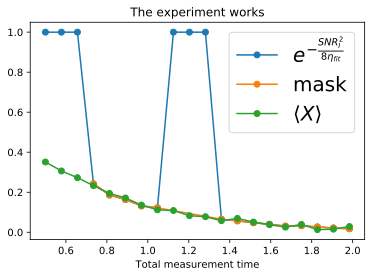

In [21]:
#plt.plot(final_times, np.exp(-SNRsqu_I_list/8/eta), 'o-',  label=r'$e^{-\frac{SNR^2_I}{8 \eta}}$')
plt.plot(final_times, np.exp(-SNRsqu_I_list/8/eta_fitted), 'o-',  label=r'$e^{-\frac{SNR^2_I}{8 \eta_{fit}}}$')
plt.plot(final_times[mask], np.exp(-SNRsqu_I_list/8/eta_fitted_mask)[mask], 'o-',  label=r'mask')
#plt.plot(final_times, np.exp(-SNRsqu_Q_list/8/eta), 'o-', label=r'$e^{-\frac{SNR^2_Q}{8 \eta}}$')
plt.plot(final_times, exp_X_list, 'o-', label=r'$\langle X \rangle$')
plt.title('The experiment works')
plt.xlabel('Total measurement time')
plt.legend(fontsize=20)
plt.show()

In [22]:
print('--- WRAP UP ---')
print('We put in as an argument a quantum efficiency eta of {:.3f}%.'.format(eta*100))
print('We generated measurement data using different integration times.')
print('We obtained from that a quantum efficiency eta_fit of {:.3f}%.'.format(eta_fitted[0]*100))
print('This corresponds to the original eta divided by 2: {:.3f}%.'.format(eta/2*100))

--- WRAP UP ---
We put in as an argument a quantum efficiency eta of 85.000%.
We generated measurement data using different integration times.
We obtained from that a quantum efficiency eta_fit of 42.628%.
This corresponds to the original eta divided by 2: 42.500%.


### The $\eta$ obtained by this experiment is 1/2 the $\eta$ we need to feed to our smesolve() trajectory generation.

We obtain the same result if we would have prepared the $|0\rangle$ and $|1\rangle$ states to build the two distributions instead of distilling the double gaussian from the $|+\rangle$ preparation used to obtain $\langle X\rangle$ (results not shown).

The end.